**Importing the Dependencies**

In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
import glob
import os
import visualkeras
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout , BatchNormalization
from keras import regularizers
from keras.layers.core import Dropout
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from glob import glob
from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D
from keras.applications.vgg16 import VGG16

#Adding the Callbacks, e.g. ModelCheckpoints, earlystopping, csvlogger.
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
from sklearn.naive_bayes import GaussianNB

**Resizing the image and Loading the dataset**

In [54]:
# re-size all the images
IMAGE_SIZE = [224, 224]
#loading the data
train_path = r"C:\Users\Computing\Downloads\data-task1\data-task1\train"
test_path = r"C:\Users\Computing\Downloads\data-task1\data-task1\test"
val_path = r"C:\Users\Computing\Downloads\data-task1\data-task1\val"

**Adding Preprocessing layers for VGG16 MODEL**

In [55]:
vgg16_model = VGG16(input_shape=(224,224,3),include_top=False,weights='imagenet')

In [56]:
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [57]:
# useful for getting number of classes
folders = glob(r"C:\Users\Computing\Downloads\data-task1\data-task1\train\*")

In [58]:
# don't train existing weights
for layer in vgg16_model.layers:
  layer.trainable = False
# our layers - you can add more if you want
#x=Conv2D(64)
x= Conv2D(filters=128, kernel_size=(3,3), activation='relu',padding='same', input_shape=(224, 224, 3)),MaxPooling2D(pool_size=(2,2))
x= Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same'),MaxPooling2D(pool_size=(2,2))
x= Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'),MaxPooling2D(pool_size=(2,2))
x= Conv2D(filters=32, kernel_size=(3,3), activation='relu',padding='same'),MaxPooling2D(pool_size=(2,2)),
#x= Conv2D(6,3,3,input_shape=(224,224,3),activation='relu')
x = Flatten()(vgg16_model.output)
x = Dense(1000, activation='relu')(x)

prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model = Model(inputs=vgg16_model.input, outputs=prediction)

# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)


In [59]:
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

**Visualization of the model**

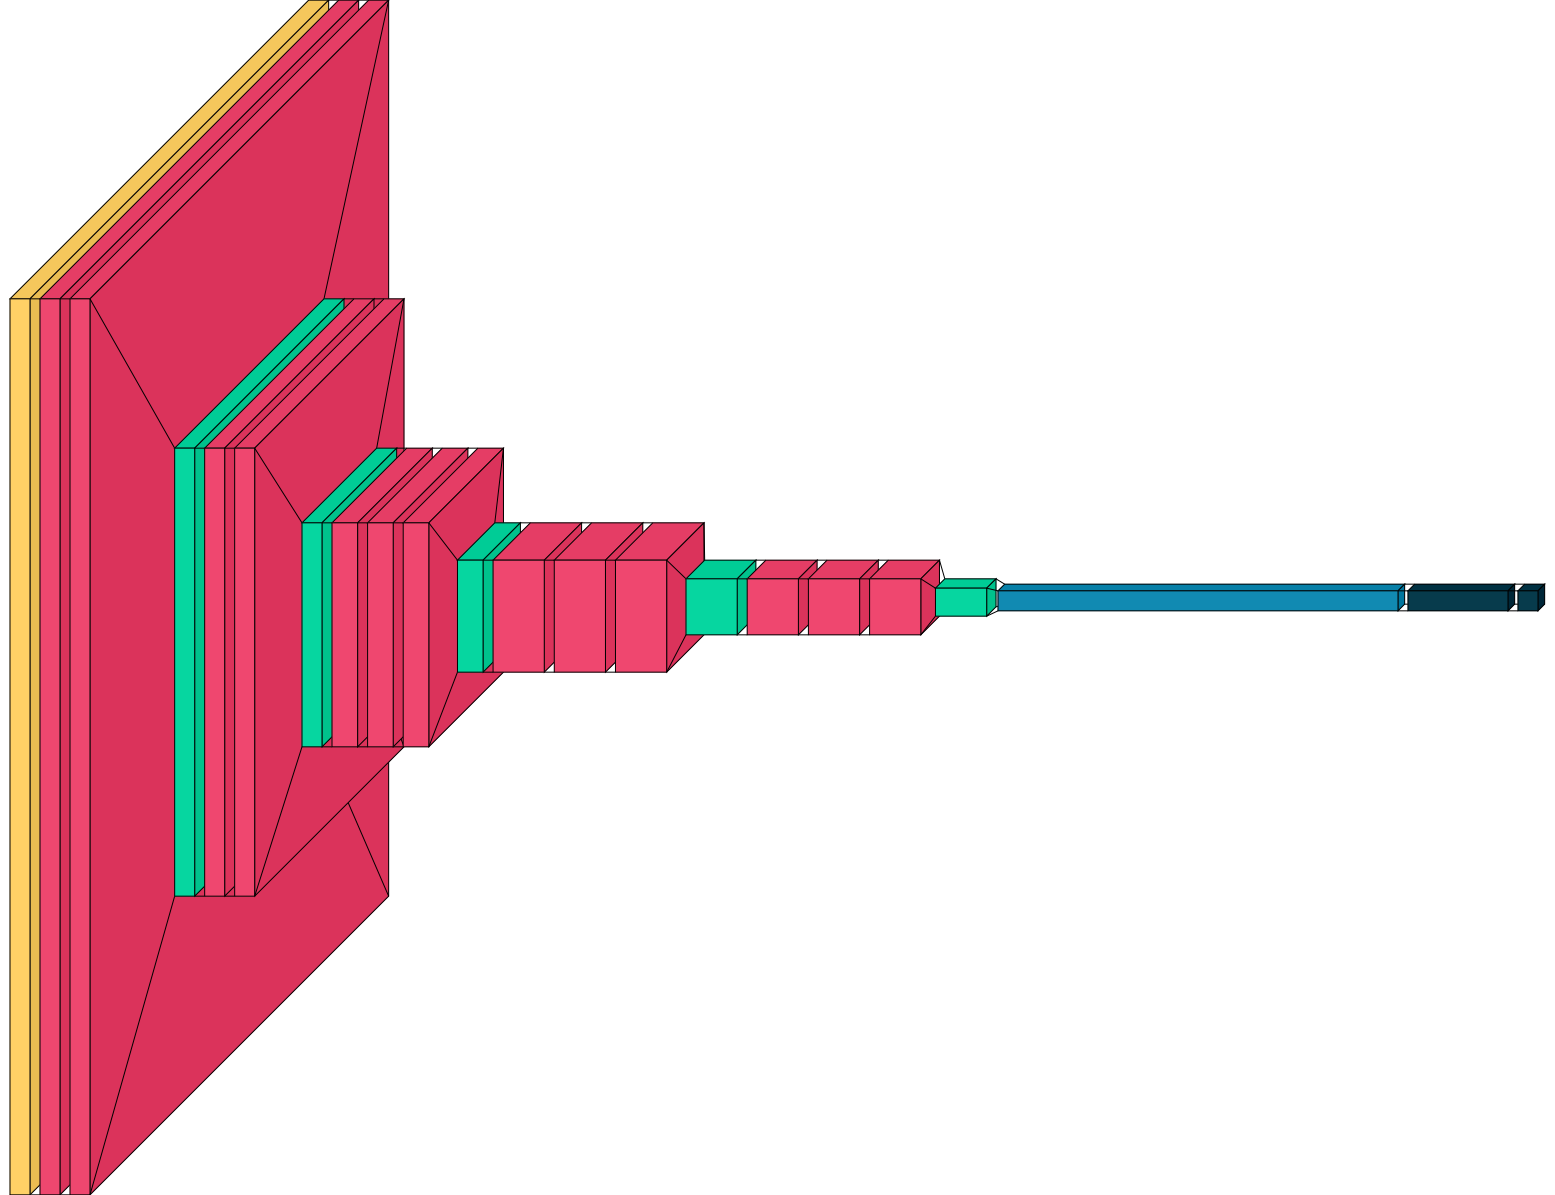

In [60]:
visualkeras.layered_view(model).show() # display using your system viewer
##visualkeras.layered_view(model, to_file='output.png') # write to disk
visualkeras.layered_view(model, to_file='output.png').show() # write and show

visualkeras.layered_view(model)

**Data Augmentation and preparing Image data generator**

In [61]:
train_datagen = ImageDataGenerator(rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,                # Applaying these all Data Augmentations
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale = 1./255)

In [62]:
training_set = train_datagen.flow_from_directory(r"C:\Users\Computing\Downloads\data-task1\data-task1\train",
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 3000 images belonging to 2 classes.


In [63]:
test_set = test_datagen.flow_from_directory(r"C:\Users\Computing\Downloads\data-task1\data-task1\test",
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')


Found 500 images belonging to 2 classes.


**Callback Functions**

In [68]:
#Adding the Callbacks, e.g. ModelCheckpoints, earlystopping, csvlogger.
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger

In [69]:
#ModelCheckpoint callback saves a model at some interval. 
filepath=r"C:\Users\Computing\Downloads\data-task1\data-task1\VGG16_model.hdf5" #File name includes epoch and validation accuracy.
#Use Mode = max for accuracy and min for loss. 
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [70]:
#https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, min_delta=0.001, mode='min', verbose=1)
#This callback will stop the training when there is no improvement in
# the validation loss for eight consecutive epochs.

In [71]:
#CSVLogger logs epoch, acc, loss, val_acc, val_loss
log_csv = CSVLogger('my_logsvgg.csv', separator=',', append=False)

callbacks_list = [checkpoint, early_stop, log_csv]

**Fit the model**

In [72]:
#Training the neural network
#We can now use these generators to train our model. 
#Give this a name so we can call it later for plotting loss, accuracy etc. as a function of epochs.
# fit the model
history = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=25,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set),
 callbacks= callbacks_list)

model.save('vgg16new_model.hdf5')  # always save your weights after training or during training

<ipython-input-72-956ec6ef6f73>:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/25
94/94 [==============================] - 176s 2s/step - loss: 1.9665 - accuracy: 0.7267 - val_loss: 0.6030 - val_accuracy: 0.8020
Epoch 2/25
94/94 [==============================] - 180s 2s/step - loss: 0.5364 - accuracy: 0.7817 - val_loss: 0.4365 - val_accuracy: 0.8000
Epoch 3/25
94/94 [==============================] - 194s 2s/step - loss: 0.5545 - accuracy: 0.7727 - val_loss: 0.6179 - val_accuracy: 0.7940
Epoch 4/25
94/94 [==============================] - 194s 2s/step - loss: 0.5426 - accuracy: 0.7843 - val_loss: 0.4623 - val_accuracy: 0.7660
Epoch 5/25
94/94 [==============================] - 185s 2s/step - loss: 0.4220 - accuracy: 0.8083 - val_loss: 0.4264 - val_accuracy: 0.8000
Epoch 6/25
94/94 [==============================] - 187s 2s/step - loss: 0.4273 - accuracy: 0.8087 - val_loss: 0.5325 - val_accuracy: 0.7060
Epoch 7/25
94/94 [==============================] - 184s 2s/step - loss: 0.4329 - accuracy: 0.7980 - val_loss: 0.5076 - val_accuracy: 0.7880
Epoch 8/25
94

**Plotting the Loss and Accuracy Curve**

Values stored in history are ... 
 {'loss': [1.9664949178695679, 0.5363872051239014, 0.5544909834861755, 0.542585551738739, 0.4219789505004883, 0.4272672235965729, 0.43294987082481384, 0.42465946078300476, 0.41997307538986206, 0.4123537540435791, 0.4226158857345581, 0.40974125266075134, 0.41649967432022095], 'accuracy': [0.7266666889190674, 0.7816666960716248, 0.7726666927337646, 0.784333348274231, 0.8083333373069763, 0.8086666464805603, 0.7979999780654907, 0.8109999895095825, 0.8063333630561829, 0.8050000071525574, 0.8040000200271606, 0.8113333582878113, 0.8013333082199097], 'val_loss': [0.603049099445343, 0.4365200102329254, 0.6179090142250061, 0.46231982111930847, 0.42642128467559814, 0.5324671864509583, 0.5075566172599792, 0.42137715220451355, 0.5101000070571899, 0.4655289053916931, 0.495388925075531, 0.4325375556945801, 0.42259785532951355], 'val_accuracy': [0.8019999861717224, 0.800000011920929, 0.7940000295639038, 0.765999972820282, 0.800000011920929, 0.7059999704360962, 0.78799

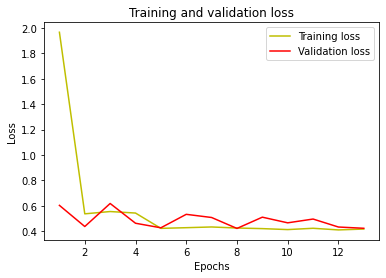

In [73]:
#plot the training and validation accuracy and loss at each epoch
print("Values stored in history are ... \n", history.history)
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Values stored in history are ... 
 {'loss': [1.9664949178695679, 0.5363872051239014, 0.5544909834861755, 0.542585551738739, 0.4219789505004883, 0.4272672235965729, 0.43294987082481384, 0.42465946078300476, 0.41997307538986206, 0.4123537540435791, 0.4226158857345581, 0.40974125266075134, 0.41649967432022095], 'accuracy': [0.7266666889190674, 0.7816666960716248, 0.7726666927337646, 0.784333348274231, 0.8083333373069763, 0.8086666464805603, 0.7979999780654907, 0.8109999895095825, 0.8063333630561829, 0.8050000071525574, 0.8040000200271606, 0.8113333582878113, 0.8013333082199097], 'val_loss': [0.603049099445343, 0.4365200102329254, 0.6179090142250061, 0.46231982111930847, 0.42642128467559814, 0.5324671864509583, 0.5075566172599792, 0.42137715220451355, 0.5101000070571899, 0.4655289053916931, 0.495388925075531, 0.4325375556945801, 0.42259785532951355], 'val_accuracy': [0.8019999861717224, 0.800000011920929, 0.7940000295639038, 0.765999972820282, 0.800000011920929, 0.7059999704360962, 0.78799

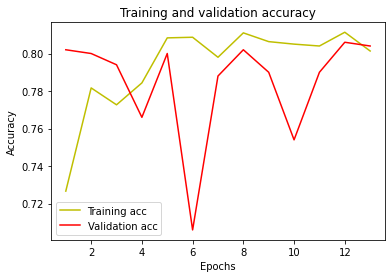

In [74]:
#plot the training and validation accuracy and loss at each epoch
print("Values stored in history are ... \n", history.history)
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

**Evaluation part of the model**

In [75]:
#Evaluating the model
train_loss, train_acc = model.evaluate(training_set, steps=32)
validation_loss, test_acc = model.evaluate(test_set, steps=32)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

32/32 [==============================] - 24s 722ms/step - loss: 0.4226 - accuracy: 0.8040
Train: 0.794, Test: 0.804


In [76]:
train_loss, train_acc = model.evaluate(training_set, steps=32)
test_loss, test_acc = model.evaluate(test_set, steps=32)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

32/32 [==============================] - 24s 723ms/step - loss: 0.4226 - accuracy: 0.8040
Train: 0.818, Test: 0.804


In [77]:
# Evaluate the model
scores = model.evaluate_generator(test_set)
print("Loss of the model: %.2f"%(scores[0]))
print("Test Accuracy: %.2f%%"%(scores[1] * 100))

<ipython-input-77-d33ba6da31cf>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  scores = model.evaluate_generator(test_set)


Loss of the model: 0.42
Test Accuracy: 80.40%


In [78]:
scores = model.evaluate_generator(training_set)
print("Loss of the model: %.2f"%(scores[0]))
print("Training Accuracy: %.2f%%"%(scores[1] * 100))

<ipython-input-78-ddfd143517da>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  scores = model.evaluate_generator(training_set)


Loss of the model: 0.42
Training Accuracy: 80.60%


**Confusion matrix**

In [79]:
test_pred = model.predict_generator(test_set)
y_pred = np.argmax(test_pred, axis=1)

<ipython-input-79-c14bf3b956d5>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  test_pred = model.predict_generator(test_set)


<Figure size 432x288 with 0 Axes>

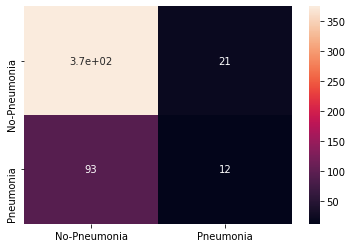

<Figure size 432x288 with 0 Axes>

In [80]:
#Visualizing confusion matrix
cm = confusion_matrix(test_set.labels,y_pred)

sns.heatmap(cm,annot=True,xticklabels=['No-Pneumonia', 'Pneumonia'],
            yticklabels=['No-Pneumonia', 'Pneumonia'])
plt.figure()
#plt.xlabel('Predicted labels')
#plt.ylabel('True labels')

**TP=TRUE POSITIVE, FP=FALSE POSITIVE, TN=TRUE NEGATIVE, FN=FALSE NEGATIVE**

In [81]:
TN, FP, FN, TP = cm.ravel()
print(TN, FP, FN, TP)

374 21 93 12


**Confusion matrix, Precision-Recall, TP/FP rates, f1-score**


In [82]:
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
test_pred = model.predict_generator(test_set)
#preds = model.predict(test_set)

#acc = accuracy_score([y_pred, np.round(test_pred)]*100).transpose()
acc = accuracy_score(test_set.labels, np.round(y_pred))*100
cm = confusion_matrix(test_set.labels, np.round(y_pred))
classify_report = classification_report(test_set.labels, np.round(y_pred))


TN, FP, FN, TP = cm.ravel() 
print('CONFUSION MATRIX ------------------')
print(cm)

print('\nTEST METRICS ----------------------')
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1 = 2 * precision * recall / (precision + recall)
#precision = TP/(TP+FP)*100
#recall = TP/(TP+FN)*100
print('Accuracy: {}%'.format(acc))
print('Precision: {}%'.format(precision))
print('Recall: {}%'.format(recall))
print('F1-score: {}'.format(2*precision*recall/(precision+recall)))

print('\nTRAIN METRIC ----------------------')
print('Train acc: {}%'.format(np.round((history.history['accuracy'][-1])*100, 2)))

# print classification report
print('Classification report on test data')
print(classify_report)

<ipython-input-82-44768ab77d36>:4: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  test_pred = model.predict_generator(test_set)


CONFUSION MATRIX ------------------
[[374  21]
 [ 93  12]]

TEST METRICS ----------------------
Accuracy: 77.2%
Precision: 0.36363636363636365%
Recall: 0.11428571428571428%
F1-score: 0.17391304347826086

TRAIN METRIC ----------------------
Train acc: 80.13%
Classification report on test data
              precision    recall  f1-score   support

           0       0.80      0.95      0.87       395
           1       0.36      0.11      0.17       105

    accuracy                           0.77       500
   macro avg       0.58      0.53      0.52       500
weighted avg       0.71      0.77      0.72       500



**TPR=TRUE POSITIVE RATE, 
FPR=FALSE POSITIVE RATE, 
TNR=TRUE NEGATIVE RATE, 
FNR=FALSE NEGATIVE RATE**

In [83]:
TPR = TP / (TP + FN)
TNR = TN / (TP + TN)
FPR = FP / (TP + FN)
FNR = FN / (FP + TN)

print('TRUE POSITIVE RATE is: {}'.format(TPR))
print('TRUE NEGATIVE RATE is: {}'.format(TNR))
print('FALSE POSITIVE RATE is: {}'.format(FPR))
print('FALSE NEGATIVE RATE is: {}'.format(FNR))

TRUE POSITIVE RATE is: 0.11428571428571428
TRUE NEGATIVE RATE is: 0.9689119170984456
FALSE POSITIVE RATE is: 0.2
FALSE NEGATIVE RATE is: 0.23544303797468355


**Prediction of the model**

In [84]:
from PIL import Image, ImageEnhance
from keras.applications.imagenet_utils import preprocess_input
from keras.models import load_model

Person is Affected By PNEUMONIA


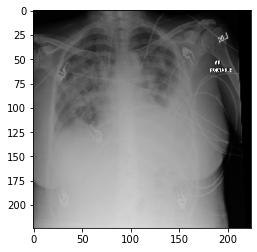

In [85]:
model=load_model('CNN_model1.hdf5')
img=image.load_img(r"C:\Users\Computing\Downloads\data-task1\data-task1\train\pneumonia\00a05408-8291-4231-886e-13763e103161.png",target_size=(224,224))
x=image.img_to_array(img)
x=np.expand_dims(x, axis=0)
img_data=preprocess_input(x)
classes=model.predict(img_data)
result=int(classes[0][0])

if result==0:
    print("Person is Affected By PNEUMONIA")
else:
    print("Person is not affected by PNEUMONIA")
plt.figure()
plt.imshow(img)

Person is not affected by PNEUMONIA


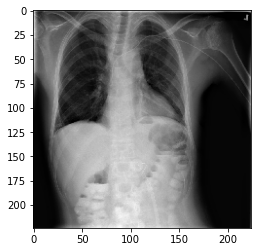

In [86]:
model=load_model('CNN_model1.hdf5')
img=image.load_img(r"C:\Users\Computing\Downloads\data-task1\data-task1\train\no_pneumonia\0a5c4dcb-33ac-4466-9dbf-42ed5c8ec1f0.png",target_size=(224,224))
x=image.img_to_array(img)
x=np.expand_dims(x, axis=0)
img_data=preprocess_input(x)
classes=model.predict(img_data)
result=int(classes[0][0])

if result==0:
    print("Person is Affected By PNEUMONIA")
else:
    print("Person is not affected by PNEUMONIA")
    plt.figure()
plt.imshow(img)